# Deep KNN method

This notebook aims at evaluating the **DKNN method**.

The method consists in performing K-Nearest-Neighbors in the feature space of a neural network trained on the in-distribution dataset.

Here, we focus on a ResNet18 network trained on MNIST, MNIST(0-4) and CIFAR-10. This model is challenged on
Fashion MNIST, MNIST (5-9), SVHN, LSUN, iSUN, and Texture OOD dataset.

**Reference**
[Out-of-Distribution Detection with Deep Nearest Neighbors](http://arxiv.org/abs/2204.06507), ICML 2022.

Some imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, PILToTensor, Resize

from oodeel.methods import DKNN
from oodeel.eval.metrics import bench_metrics
from oodeel.datasets import OODDataset
from oodeel.models.training_funs import train_convnet_classifier_torch, train_torch_model

Note that models are saved at *~/.oodeel/saved_models* and data is supposed to be found at *~/.oodeel/datasets* by default. Change the following cell for a custom path.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## MNIST (0-4) vs MNIST (5-9)

### Data and model loading

* in-distribution data: MNIST (0-4), 
* out-of-distribution data: MNIST (5-9)

/!\ We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD) data with `_out` to avoid confusion with OOD detection which is the name of the task, and is therefore used to denote core classes such as `OODDataset` and `OODModel`.

In [3]:
oods_train = OODDataset('MNIST', split="train", backend="torch", load_kwargs={"root": data_path, "download": True})
oods_test = OODDataset('MNIST', split="test", backend="torch", load_kwargs={"root": data_path, "download": True})

batch_size = 128
inc_labels = [0, 1, 2, 3, 4]
oods_train, _ = oods_train.assign_ood_labels_by_class(in_labels=inc_labels)
oods_in, oods_out = oods_test.assign_ood_labels_by_class(in_labels=inc_labels)

def preprocess_fn(inputs):
    x = inputs[0] / 255.0
    return tuple([x] + list(inputs[1:]))

ds_train = oods_train.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)
ds_in = oods_in.prepare(batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn)

Filtering the dataset...: 100%|██████████| 60000/60000 [00:04<00:00, 12687.39it/s]


In [4]:

model_path_mnist_04 = os.path.join(model_path, "mnist_model_0-4")

try:
    model = torch.load(os.path.join(model_path_mnist_04, "best.pt"))
except OSError:
    train_config = {
        "input_shape": (1, 28, 28),
        "num_classes": 10,
        "batch_size": 128,
        "is_prepared": True,
        "epochs": 5,
        "save_dir": model_path_mnist_04,
        "validation_data": ds_in  # ds_in is actually the test set of MNIST [0-4]
    }

    model = train_convnet_classifier_torch(ds_train, **train_config) #ds_train is actually the train set of MNIST [0-4]

model.eval()
model = model.to(device)

### DKNN score

Extracting the dataset features...: 100%|██████████| 240/240 [00:03<00:00, 77.94it/s] 


auroc       0.966587
fpr95tpr    0.135769
Name: mnist-0-4-vs-5-10, dtype: float64


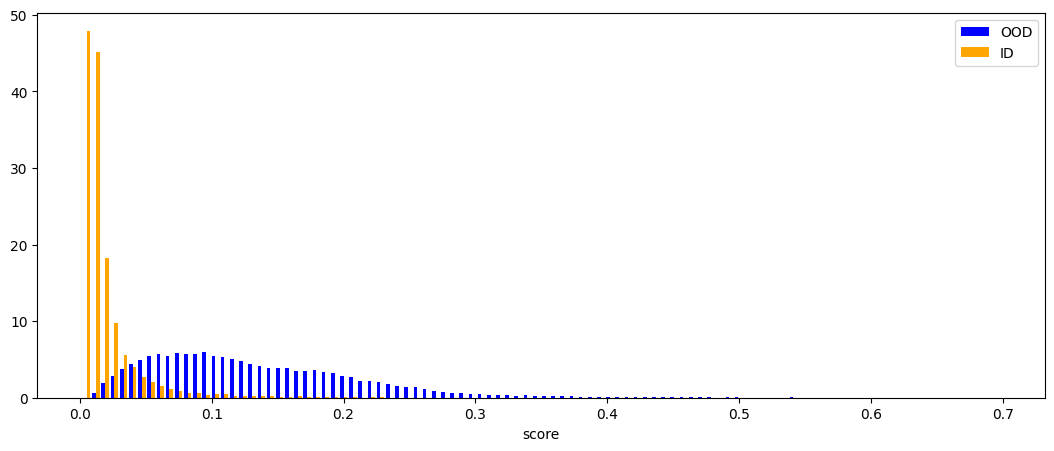

In [5]:
batch_size = 128

oodmodel = DKNN(nearest=50)
oodmodel.fit(model, ds_train)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr"], 
    )

metrics_first_vs_last = pd.Series(metrics, name='mnist-0-4-vs-5-10')
print(metrics_first_vs_last)

# plot hists / roc
plt.figure(figsize=(13, 5))
plt.hist((scores_out, scores_in), bins=100, color=("blue", "orange"), label=("OOD", "ID"), density=True)
plt.xlabel("score")
plt.legend()
plt.show()

## MNIST vs Fashion MNIST


### Data and model loading
ID data: MNIST, OOD data: Fashion MNIST

In [6]:
oods_in = OODDataset('MNIST', backend="torch", load_kwargs={"root": data_path, "train": False, "download": True})
oods_out = OODDataset('FashionMNIST', backend="torch", load_kwargs={"root": data_path, "train": False, "download": True})
oods_train = OODDataset('MNIST', backend="torch", load_kwargs={"root": data_path, "train": True, "download": True})

batch_size = 128
ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_train = oods_train.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)

In [7]:
model_path_mnist = os.path.join(model_path, "mnist_model")

try:
    model = torch.load(os.path.join(model_path_mnist, "best.pt"))
    
except OSError:
    train_config = {
        "input_shape": (1, 28, 28),
        "num_classes": 10,
        "batch_size": 128,
        "is_prepared": True,
        "epochs": 5,
        "save_dir": model_path_mnist,
        "validation_data": ds_in  # ds_in is actually the test set of MNIST
    }

    model = train_convnet_classifier_torch(ds_train, **train_config) #

model.eval()
model = model.to(device)

### DKNN score

Extracting the dataset features...: 100%|██████████| 469/469 [00:03<00:00, 128.09it/s]


auroc       0.914095
fpr95tpr    0.246400
Name: mnist-10-vs-fashion, dtype: float64


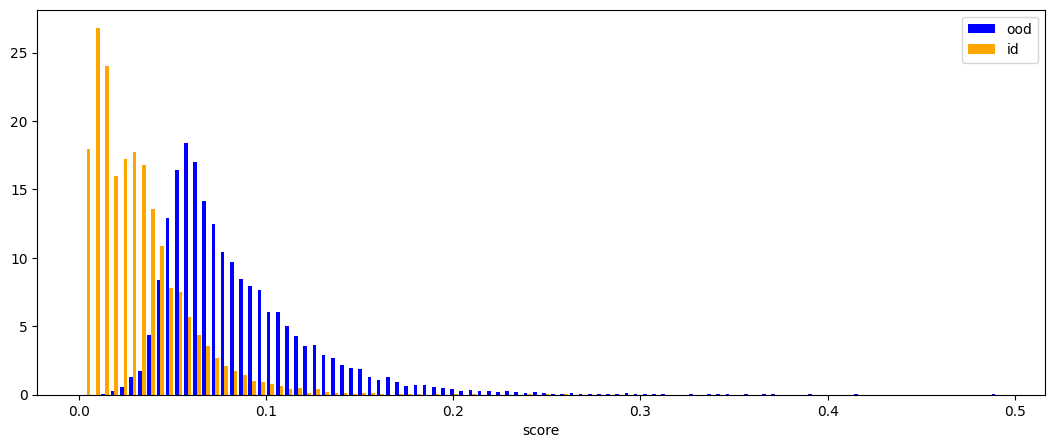

In [8]:
oodmodel = DKNN(nearest=50)
oodmodel.fit(model, ds_train)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)


metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr",], 
    )
metrics_fashion = pd.Series(metrics, name='mnist-10-vs-fashion')
print(metrics_fashion)

# plot hists / roc
plt.figure(figsize=(13, 5))
plt.hist((scores_out, scores_in), bins=100, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.xlabel("score")
plt.legend()
plt.show()

## CIFAR-10 vs [SVHN, LSUN, iSUN, Texture]

### ID Data and model loading

In [9]:
oods_in = OODDataset('CIFAR10', backend="torch", load_kwargs={"root": data_path, "train": False, "download": True})
oods_train = OODDataset('CIFAR10', backend="torch", load_kwargs={"root": data_path, "train": False, "download": True})

def preprocess_fn(inputs):
    x = inputs[0] / 255.0
    x = transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2023, 0.1994, 0.2010)
    )(x)
    return tuple([x] + list(inputs[1:]))

batch_size = 128
ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_train = oods_train.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [10]:
model_path_cifar = os.path.join(model_path, "cifar10")
try:
    # model = torch.load(os.path.join(model_path_cifar, "best.pt"))
    model = torch.load(os.path.join(model_path_cifar, "dknn_cifar10.pt"))  # pretrained resnet18

except OSError:
    train_config = {
        "input_shape": (3, 32, 32),
        "num_classes": 10,
        "batch_size": 128,
        "is_prepared": True,
        "epochs": 200,
        "save_dir": model_path_cifar,
        "validation_data": ds_in  # ds_in is actually the test set of CIFAR10
    }

    model = train_torch_model(ds_train, "resnet18", **train_config)

model.eval()
model = model.to(device)

In [11]:
# check accuracy of classifier
tp = []
model.eval()
for batch_x, batch_y in ds_in:
    preds = torch.argmax(model(batch_x.to(device)).detach().cpu(), -1)
    tp.append((preds == batch_y))
accuracy = torch.cat(tp).type(torch.float).mean()
print(accuracy)

tensor(0.9421)


In [12]:
# ood dataset
oodmodel = DKNN(nearest=50, output_layers_id=['avgpool'])
oodmodel.fit(model, ds_train)
scores_in = oodmodel.score(ds_in)

Extracting the dataset features...: 100%|██████████| 79/79 [00:01<00:00, 52.71it/s]


### OOD data: SVHN
ID data: CIFAR-10, OOD data: SVHN

Using downloaded and verified file: /home/yannick.prudent/.oodeel/datasets/test_32x32.mat
auroc       0.959801
fpr95tpr    0.166800
Name: cifar-vs-svhn, dtype: float64


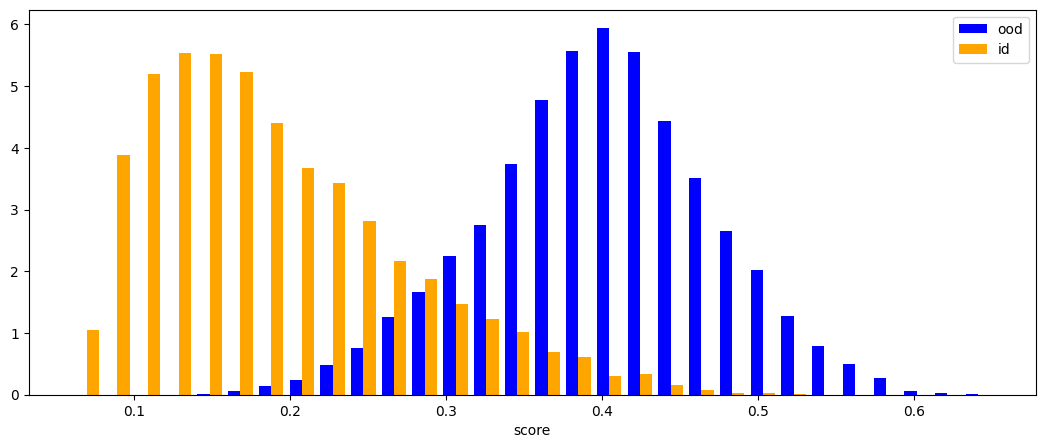

In [13]:
oods_out = OODDataset('SVHN', backend="torch", load_kwargs={"root": data_path, "split": "test", "download": True})

ds_out = oods_out.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)

scores_out = oodmodel.score(ds_out)

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_svhn = pd.Series(metrics, name='cifar-vs-svhn')
print(metrics_cifar_svhn)

# plot hists / roc
plt.figure(figsize=(13, 5))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.xlabel("score")
plt.legend()
plt.show()

### OOD data: LSUN
ID data: CIFAR-10, OOD data: LSUN

auroc       0.972223
fpr95tpr    0.137600
Name: cifar-vs-lsun, dtype: float64


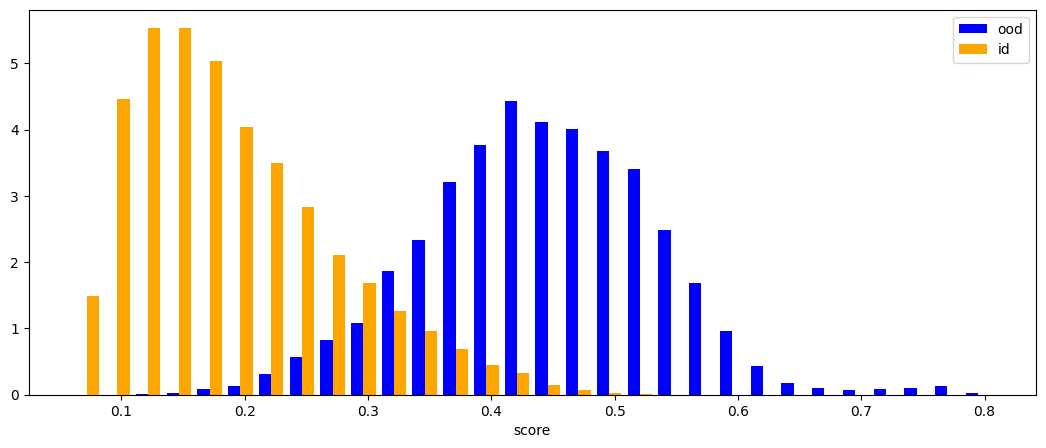

In [14]:
image_folder_transform = Compose([PILToTensor(), Resize((32, 32))])

# LSUN
lsun_kwargs = {"root": os.path.join(data_path, "LSUN_tvs"), "transform": image_folder_transform}

# ood dataset
ds_out = OODDataset(ImageFolder(**lsun_kwargs), backend="torch").prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
scores_out = oodmodel.score(ds_out)

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_lsun = pd.Series(metrics, name='cifar-vs-lsun')
print(metrics_cifar_lsun)

# plot hists / roc
plt.figure(figsize=(13, 5))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.xlabel("score")
plt.legend()
plt.show()

### OOD data: iSUN
ID data: CIFAR-10, OOD data: iSUN

auroc       0.954009
fpr95tpr    0.205600
Name: cifar-vs-isun, dtype: float64


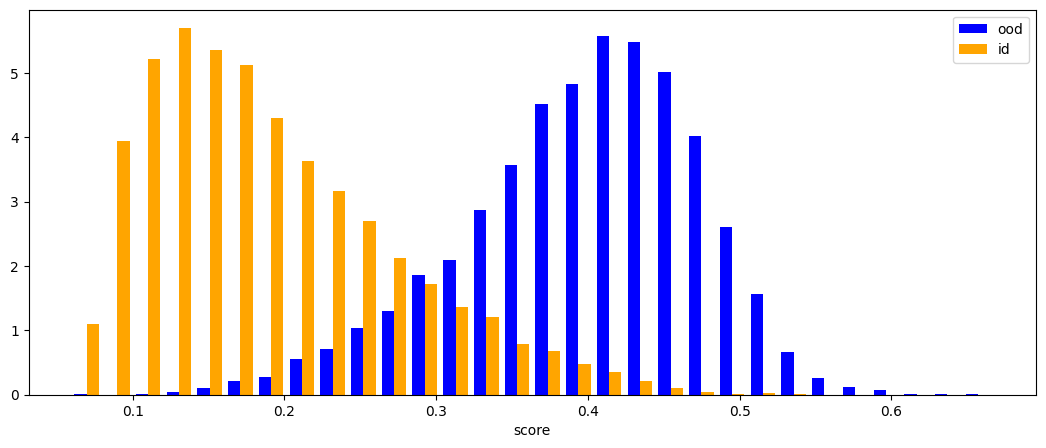

In [15]:
image_folder_transform = Compose([PILToTensor(), Resize((32, 32))])

# iSUN
isun_kwargs = {"root": os.path.join(data_path, "iSUN"), "transform": image_folder_transform}

# ood dataset
ds_out = OODDataset(ImageFolder(**isun_kwargs), backend="torch").prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
scores_out = oodmodel.score(ds_out)

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_isun = pd.Series(metrics, name='cifar-vs-isun')
print(metrics_cifar_isun)

# plot hists / roc
plt.figure(figsize=(13, 5))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.xlabel("score")
plt.legend()
plt.show()

### OOD data: Texture
ID data: CIFAR-10, OOD data: Texture

auroc       0.948295
fpr95tpr    0.284600
Name: cifar-vs-texture, dtype: float64


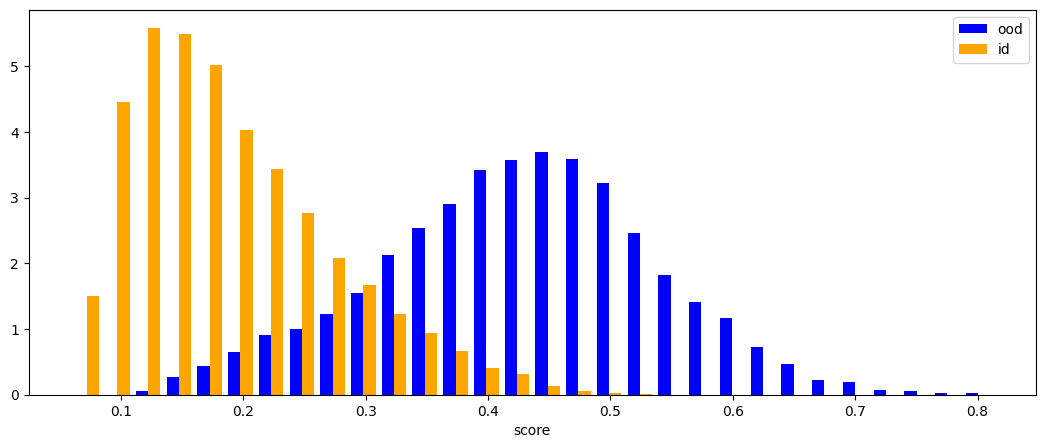

In [16]:
image_folder_transform = Compose([PILToTensor(), Resize((32, 32))])

# Texture
texture_kwargs = {"root": os.path.join(data_path, "dtd", "images"), "transform": image_folder_transform}

# ood dataset
ds_out = OODDataset(ImageFolder(**texture_kwargs), backend="torch").prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
scores_out = oodmodel.score(ds_out)

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_texture = pd.Series(metrics, name='cifar-vs-texture')
print(metrics_cifar_texture)

# plot hists / roc
plt.figure(figsize=(13, 5))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.xlabel("score")
plt.legend()
plt.show()

## Results

In [17]:
pd.concat([metrics_first_vs_last, metrics_fashion, metrics_cifar_svhn, metrics_cifar_lsun, metrics_cifar_isun, metrics_cifar_texture], axis=1).T

,auroc,fpr95tpr
mnist-0-4-vs-5-10,0.966587,0.135769
mnist-10-vs-fashion,0.914095,0.246400
cifar-vs-svhn,0.959801,0.166800
cifar-vs-lsun,0.972223,0.137600
cifar-vs-isun,0.954009,0.205600
cifar-vs-texture,0.948295,0.284600
